In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN


In [3]:
df = pd.read_csv("Churn_Modelling.csv")
df.drop(columns=["CustomerId", "Surname"], inplace=True)
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)

features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
            'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'IsActiveMember', 'HasCrCard']
X = df[features]
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

## Evaluate a bunch of models and data sampling approaches for further finetuning: 

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, 
        solver='liblinear', 
        penalty='l2', 
        C=1.0
    ),
    "XGBoost": xgb.XGBClassifier(
        eval_metric='mlogloss', 
        n_estimators=300, 
        max_depth=6, 
        learning_rate=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8, 
        gamma=0.1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=400, 
        max_depth=10, 
        min_samples_split=10, 
        min_samples_leaf=4, 
        max_features='sqrt', 
        class_weight='balanced_subsample', 
        random_state=42
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(
        max_depth=5, 
        min_samples_split=10, 
        min_samples_leaf=4, 
        class_weight=None, 
        random_state=42
    )
}

sampling_techniques = {
    "None": None,
    "SMOTEENN": SMOTEENN(),
    "Oversampling": RandomOverSampler(sampling_strategy='minority'),
    "Undersampling": RandomUnderSampler(sampling_strategy='majority'),
    "Tomek Links": TomekLinks(),
}

def fit_model_with_sampling(X_train, y_train, model, sampling):
    if sampling:
        X_resampled, y_resampled = sampling.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train
    model.fit(X_resampled, y_resampled)
    return model

for model_name, model in models.items():
    print(f"Evaluating {model_name}:\n{'=' * 40}")

    for sampling_name, sampling in sampling_techniques.items():
        print(f"Sampling technique: {sampling_name}")
        
        model_with_sampling = fit_model_with_sampling(X_train_scaled, y_train, model, sampling)
        
        y_pred = model_with_sampling.predict(X_test_scaled)

        print(classification_report(y_test, y_pred))


Evaluating Logistic Regression:
Sampling technique: None
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2627
           1       0.57      0.22      0.31       673

    accuracy                           0.81      3300
   macro avg       0.70      0.59      0.60      3300
weighted avg       0.77      0.81      0.77      3300

Sampling technique: SMOTEENN
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      2627
           1       0.34      0.79      0.48       673

    accuracy                           0.65      3300
   macro avg       0.63      0.70      0.60      3300
weighted avg       0.80      0.65      0.68      3300

Sampling technique: Oversampling
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      2627
           1       0.38      0.72      0.50       673

    accuracy                           0.71      3300
   macro 

## Finetuning: 


In [5]:
# GRID SEARCH FOR XGBClassifier

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, m

In [6]:
# best params for  XGBClassifier

model = xgb.XGBClassifier(
    gamma=0,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=1.0,
    scale_pos_weight=3,
    random_state=42
)

model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(cm)
print(report)

[[2531   96]
 [ 332  341]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2627
           1       0.78      0.51      0.61       673

    accuracy                           0.87      3300
   macro avg       0.83      0.74      0.77      3300
weighted avg       0.86      0.87      0.86      3300



In [7]:
# gridsearch for RANDOM FOREST 

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_l

In [8]:
# best params for  RANDOM FOREST  
# {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}

rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=500,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Accuracy: 0.8433
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2627
           1       0.60      0.70      0.65       673

    accuracy                           0.84      3300
   macro avg       0.76      0.79      0.77      3300
weighted avg       0.85      0.84      0.85      3300

ROC-AUC Score: 0.8807


In [9]:

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2627
           1       0.60      0.70      0.65       673

    accuracy                           0.84      3300
   macro avg       0.76      0.79      0.77      3300
weighted avg       0.85      0.84      0.85      3300

ROC-AUC Score: 0.8807


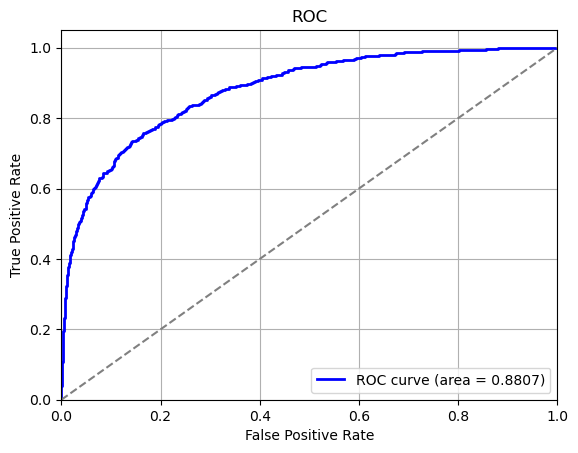

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [11]:
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validated scores: {scores}")
print(f"Mean accuracy: {scores.mean():.4f}")

Cross-validated scores: [0.8358209  0.83955224 0.8261194  0.85810306 0.82374907]
Mean accuracy: 0.8367


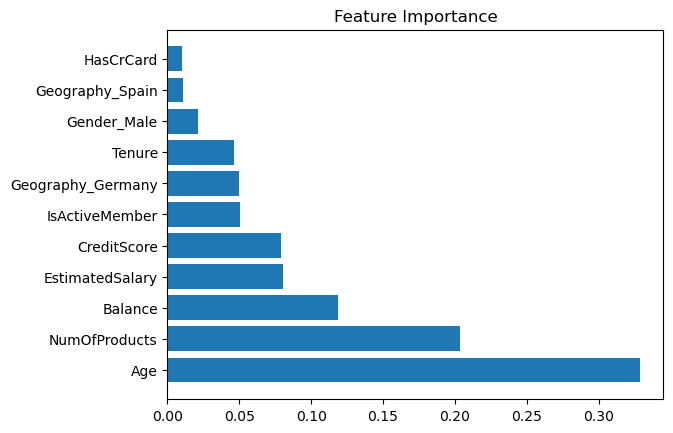

In [12]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), names)
plt.show()

In [13]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance_df.to_csv("feature_importance.csv")

In [14]:
joblib.dump(rf_model, "rf_model")
print("Success")

Success
